In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.fft

class ConvectionDiffusionDataset(Dataset):
    def __init__(self, data_folder, n_steps):
        self.data_folder = data_folder
        self.n_steps = n_steps  
        self.data = self.load_data()

    def load_data(self):
        data = np.load(f'{self.data_folder}/simulation_data.npy')
        return np.array(data)

    def __len__(self):
        return self.data.shape[0]-1

    def __getitem__(self, idx):
        u_t = self.data[idx]      
        u_t1 = self.data[idx + 1]  
        return torch.tensor(u_t[None,1:-1,1:-1], dtype=torch.float32), torch.tensor(u_t1[None,1:-1,1:-1], dtype=torch.float32)


class FourierLayer(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(FourierLayer, self).__init__()
        self.modes = modes
        # self.weights = nn.Parameter(torch.randn(out_channels, in_channels, dtype=torch.cfloat))
        self.weights = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False, dtype=torch.cfloat)

    def forward(self, x):
        x_ft = torch.fft.rfft2(x)
        x_ft = x_ft[:,:,:self.modes, :self.modes]
        out_ft = torch.zeros_like(x_ft)

        out_ft = self.weights(x_ft) #* self.weights
        
        x_out = torch.fft.irfft2(out_ft, s=x.size()[-2:])
        return x_out

class NeuralOperator(nn.Module):
    def __init__(self, modes, width):
        super(NeuralOperator, self).__init__()
        self.lifting_layer = nn.Conv2d(1, width, kernel_size=1)
        self.fourier_layer1 = FourierLayer(width, width, modes)
        self.fourier_layer2 = FourierLayer(width, width, modes)
        self.fourier_layer3 = FourierLayer(width, width, modes)
        self.fourier_layer4 = FourierLayer(width, width, modes)
        self.projection_layer = nn.Conv2d(width, 1, kernel_size=1)
        # self.conv1 = nn.Conv2d(width, width, kernel_size=1)
        # self.conv2 = nn.Conv2d(width, width, kernel_size=1)
        # self.conv3 = nn.Conv2d(width, 1, kernel_size=1)

    def forward(self, x):
        x = self.lifting_layer(x)
        x = self.fourier_layer1(x)
        x = torch.relu(x)
        x = self.fourier_layer2(x)
        x = torch.relu(x)
        x = self.fourier_layer3(x)
        x = torch.relu(x)
        x = self.fourier_layer4(x)
        x = torch.relu(x)
        x = self.projection_layer(x)
        # x = torch.relu(self.conv1(x))
        # x = torch.relu(self.conv2(x))
        # x = self.conv3(x) 
        return x 


In [12]:
data_folder = './dataset'
n_steps = 500 
dataset = ConvectionDiffusionDataset(data_folder, n_steps)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

modes = 12   
width = 32   
model = NeuralOperator(modes, width)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for u_t, u_t1 in dataloader:
        optimizer.zero_grad()
        # print(u_t.shape)
        # print(torch.fft.rfft2(u_t).shape)
        output = model(u_t)  # Predict u_t1 from u_t
        loss = criterion(output, u_t1)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}')


Epoch [1/50], Loss: 0.0119
Epoch [2/50], Loss: 0.0106
Epoch [3/50], Loss: 0.0091
Epoch [4/50], Loss: 0.0070
Epoch [5/50], Loss: 0.0053
Epoch [6/50], Loss: 0.0042
Epoch [7/50], Loss: 0.0034
Epoch [8/50], Loss: 0.0029
Epoch [9/50], Loss: 0.0024
Epoch [10/50], Loss: 0.0020
Epoch [11/50], Loss: 0.0017
Epoch [12/50], Loss: 0.0015
Epoch [13/50], Loss: 0.0014
Epoch [14/50], Loss: 0.0013
Epoch [15/50], Loss: 0.0011
Epoch [16/50], Loss: 0.0011
Epoch [17/50], Loss: 0.0010
Epoch [18/50], Loss: 0.0009
Epoch [19/50], Loss: 0.0008
Epoch [20/50], Loss: 0.0008
Epoch [21/50], Loss: 0.0007
Epoch [22/50], Loss: 0.0007
Epoch [23/50], Loss: 0.0007
Epoch [24/50], Loss: 0.0006
Epoch [25/50], Loss: 0.0006
Epoch [26/50], Loss: 0.0005
Epoch [27/50], Loss: 0.0005
Epoch [28/50], Loss: 0.0005
Epoch [29/50], Loss: 0.0004
Epoch [30/50], Loss: 0.0004
Epoch [31/50], Loss: 0.0003
Epoch [32/50], Loss: 0.0003
Epoch [33/50], Loss: 0.0003
Epoch [34/50], Loss: 0.0003
Epoch [35/50], Loss: 0.0003
Epoch [36/50], Loss: 0.0003
E

In [14]:
model.eval()
with torch.no_grad():
    u_t, u_t1_true = dataset[0]  
    u_t = u_t.unsqueeze(0) 
    u_t1_pred = model(u_t).squeeze(0)  

    # print(u_t1_pred.shape)
    # print(u_t1_true.shape)
    error = criterion(u_t1_true, u_t1_pred)

    print("Error: ", error.item())

Error:  0.0030916512478142977


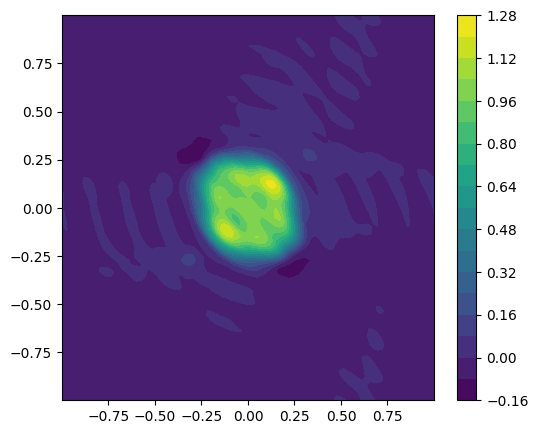

In [18]:
import matplotlib.pyplot as plt

domain = [-1,1]
dim = 2
n_dx_elements = 100
dx = (domain[1] - domain[0])/(n_dx_elements)
x = np.linspace(domain[0]-dx, domain[1]+dx, n_dx_elements+2)
y = np.linspace(domain[0]-dx, domain[1]+dx, n_dx_elements+2)
mesh_x, mesh_y = np.meshgrid(x[1:-1],y[1:-1])


fig, ax = plt.subplots(figsize=(6, 5))
contour1 = ax.contourf(mesh_x, mesh_y, u_t1_pred.squeeze(0).numpy(), levels=20, cmap='viridis')
colorbar = plt.colorbar(contour1, ax=ax)